# <center> L-TEM analysis of Magnetic Samples with MTIE</center>

<ins> Importing relevant python libraries <ins>

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy.constants as sc
from scipy.ndimage import zoom, gaussian_filter

from skimage.restoration import unwrap_phase
from skimage.transform import rotate
from skimage.measure import block_reduce

import cv2

import empyre as emp
from libertem.api import Context
from libertem.udf.raw import PickUDF
from libertem_holo.udf.reconstr import HoloReconstructUDF

from libertem_holo.base.filters import (
    clipped, disk_aperture, butterworth_disk, butterworth_line,
)
from libertem_holo.base.utils import (
    estimate_sideband_position, estimate_sideband_size, freq_array,
    HoloParams, get_slice_fft, fft_shift_coords, remove_phase_ramp,
)
from libertem_holo.base.reconstr import phase_offset_correction
from libertem_holo.base.align import align_stack, ImageCorrelator, stack_alignment_quality


This function is used to plot the Mangetic induction from phase file using "empyre" library

In [2]:
def plot_mag_induction(mean_phase_norm_crop, axis, clipper=0.1, binning=1):
    mean_phase_norm_crop = block_reduce(mean_phase_norm_crop, (binning, binning), np.mean)
    clipped_frame = clipped(mean_phase_norm_crop)
    vmin, vmax = np.min(mean_phase_norm_crop), np.max(mean_phase_norm_crop)
    
    # Represent the unwrap phase image with the 'field' class
    phase_field = emp.fields.Field(data=mean_phase_norm_crop, scale=1, vector=False)
    # Display the curl
    cmap = emp.vis.colors.cmaps.cyclic_classic
    emp.vis.colorvec(phase_field.curl().clip(vmax=clipper), vmin=vmin, vmax=vmax, cmap=cmap, origin='lower', axis=axis)
    
    # Display the cosine contours
    emp.vis.cosine_contours(phase_field, gain=10, origin='lower', axis=axis)
    emp.vis.colorwheel(cmap=cmap, axis=axis)
    plt.gca().invert_yaxis()

<ins>Step 1</ins>. Importing the Phase file

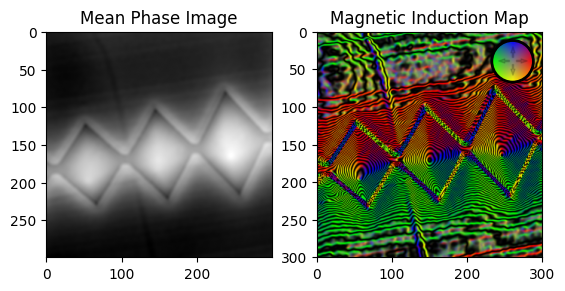

In [ ]:
pathp = r"\mean_phase_compensated.npy"
phase = np.load(pathp)
fig, ax = plt.subplots(ncols = 2)
ax[0].imshow(phase, cmap = 'gray')
ax[0].set_title('Mean Phase Image')
plot_mag_induction(phase, axis=ax[1], binning=1)
ax[1].set_title('Magnetic Induction Map')
plt.show()

<ins>Step 2<ins> Plotting the magnetic field component calculated from the phase

C:\Users\amren\AppData\Local\Temp\ipykernel_16408\3086470366.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  phase_mag = np.array(np.sqrt(phase_field.curl()[:,:,0]**2+phase_field.curl()[:,:,1]**2))


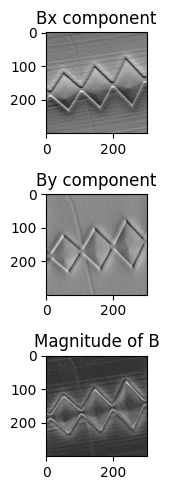

In [4]:
phase_field = emp.fields.Field(phase/np.max(phase), scale=1, vector=False)
phase_mag = np.array(np.sqrt(phase_field.curl()[:,:,0]**2+phase_field.curl()[:,:,1]**2))

plt.figure(figsize=(5,5))
plt.subplot(3,1,1)
plt.imshow(phase_field.curl()[:,:,0],cmap = 'gray')
plt.title('Bx component')
plt.subplot(3,1,2)
plt.imshow(phase_field.curl()[:,:,1], cmap = 'gray')
plt.title('By component')
plt.subplot(3,1,3)
plt.imshow(phase_mag , cmap ='gray', vmin = -0.0009, vmax = np.max(phase_mag))
plt.title('Magnitude of B')
plt.tight_layout()
plt.show()

<ins>Step 2</ins>. Importing the Mask file

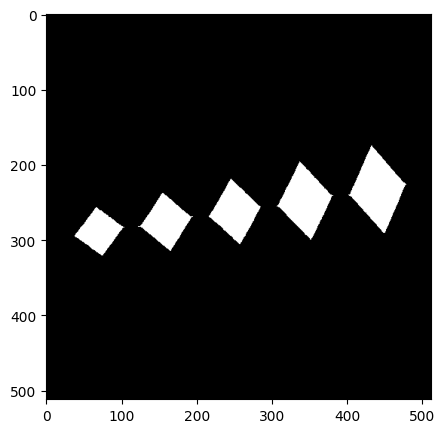

In [5]:
reu_mask = np.load("reu_mask.npy")
fig  = plt.figure(figsize =(10,5))
reu_mask_f = reu_mask[100:400,100:400]
plt.imshow(reu_mask,cmap='gray')
plt.show()

This function is used to plot the quiver plot of the magnetic field components

In [6]:
def quivermxmy(Bx,By,phase_mag,reu_mask_f,data_label):
        # Mask Bx and By
    Bx = np.where(reu_mask_f > 0, Bx, np.nan)
    By = np.where(reu_mask_f > 0, By, np.nan)

    # Compute magnitude and normalize
    magnitude = np.sqrt(Bx**2 + By**2)
    Bx_norm = Bx / magnitude
    By_norm = By / magnitude

    # Create meshgrid
    x_dim, y_dim = Bx.shape
    xv, yv = np.meshgrid(np.arange(y_dim), np.arange(x_dim))


    mx_combined = np.where(~np.isnan(reu_mask_f), Bx_norm, np.nan)
    my_combined = np.where(~np.isnan(reu_mask_f), By_norm, np.nan)

    # Bin the data (simple subsampling - change bin_factor as needed)
    bin_factor = 5  # Show every 2nd arrow
    x_binned = xv[::bin_factor, ::bin_factor]
    y_binned = yv[::bin_factor, ::bin_factor]
    mx_binned = mx_combined[::bin_factor, ::bin_factor]
    my_binned = my_combined[::bin_factor, ::bin_factor]

    # Create boolean mask for valid (non-NaN) points for quiver
    valid_mask = ~np.isnan(mx_binned) & ~np.isnan(my_binned)

    s = 15  # Scale factor for arrows
    fig  = plt.figure(figsize =(10,5))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.quiver(x_binned[valid_mask], y_binned[valid_mask], 
                -mx_binned[valid_mask], my_binned[valid_mask], 
                scale=s, color='k', width=0.01)
    plt.imshow(phase_mag, cmap='gray', alpha=0.9,vmin=-0.5*np.mean(np.abs(phase_mag)),vmax=10*np.mean(np.abs(phase_mag)))
    plt.title(data_label)  # Overlay the mask
    plt.show()

<ins>Step 3</ins>. Creating the additional mask to remove edges and noise

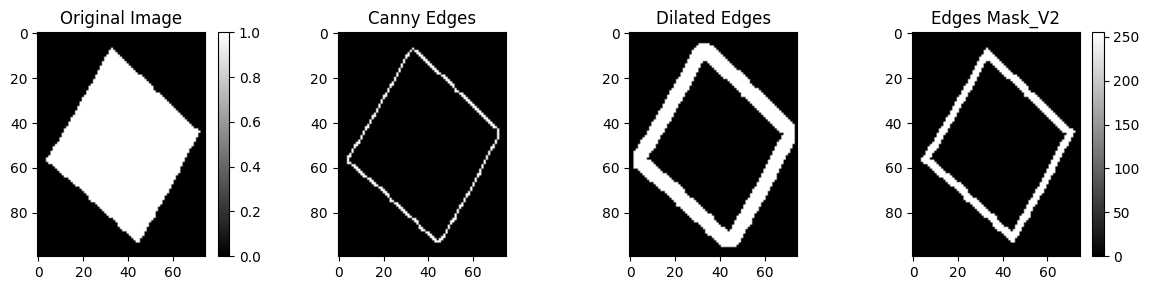

In [7]:

Bx = phase_field.curl()[:,:,0]
By = phase_field.curl()[:,:,1]

# Sample data (replace with actual data)
start = [212, 212] # for diamond V2
stop = [312, 287]  # for diamond V2

x_start_initial, x_stop_initial = 100, 400
y_start_initial, y_stop_initial = 100, 400


# Calculate the relative coordinates within the compensated phase image
rel_y_start = start[0] - y_start_initial
rel_y_stop = stop[0] - y_start_initial
rel_x_start = start[1] - x_start_initial
rel_x_stop = stop[1] - x_start_initial

# Extract mask region
mask_V2 = reu_mask_f[rel_y_start:rel_y_stop, rel_x_start:rel_x_stop]

# Convert to grayscale if needed
if len(mask_V2.shape) == 3 and mask_V2.shape[2] == 3:
    gray_image = cv2.cvtColor(mask_V2, cv2.COLOR_BGR2GRAY)
else:
    gray_image = mask_V2.astype(np.uint8)  # Ensure correct data type

# Apply Gaussian blur and Canny edge detection
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blurred_image, 1, 1)  # Adjust thresholds if needed

# Create figure for edge detection plots
fig1, ax1 = plt.subplots(1, 4, figsize=(12, 3))
ax1[0].imshow(gray_image, cmap='gray')
ax1[0].set_title('Original Image')
fig1.colorbar(ax1[0].imshow(gray_image, cmap='gray'), ax=ax1[0])

ax1[1].imshow(edges, cmap='gray')
ax1[1].set_title('Canny Edges')

# Dilate edges
kernel = np.ones((3, 3), np.uint8)
dilated_edges = cv2.dilate(edges, kernel, iterations=2)

ax1[2].imshow(dilated_edges, cmap='gray')
ax1[2].set_title('Dilated Edges')

# Apply mask to edges
edges_mask = dilated_edges * mask_V2
ax1[3].imshow(edges_mask, cmap='gray')
ax1[3].set_title('Edges Mask_V2')
fig1.colorbar(ax1[3].imshow(edges_mask, cmap='gray'), ax=ax1[3])

plt.tight_layout()
plt.show()

<ins>Step 4</ins>. Ploting the vorticity and quiver plot of magnetic field

C:\Users\amren\AppData\Local\Temp\ipykernel_16408\1409616132.py:19: RuntimeWarning: divide by zero encountered in log
  reu_mask > 0, np.where(gaussian_filter(dByV2 - dBxV2, sigma=1)> 0,np.log(gaussian_filter(dByV2 - dBxV2, sigma=1)),-10),  np.nan)[45:80,20:55],vmin=-8.8,vmax=-8.1)
C:\Users\amren\AppData\Local\Temp\ipykernel_16408\1409616132.py:19: RuntimeWarning: invalid value encountered in log
  reu_mask > 0, np.where(gaussian_filter(dByV2 - dBxV2, sigma=1)> 0,np.log(gaussian_filter(dByV2 - dBxV2, sigma=1)),-10),  np.nan)[45:80,20:55],vmin=-8.8,vmax=-8.1)


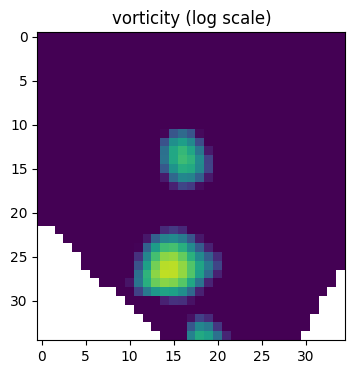

C:\Users\amren\AppData\Local\Temp\ipykernel_16408\1409616132.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  phase_mag = np.array(np.sqrt(phase_field.curl()[:,:,0]**2+phase_field.curl()[:,:,1]**2))


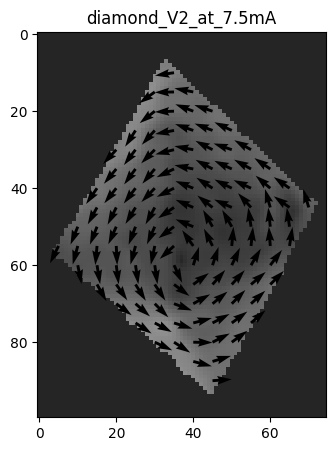

In [8]:
reu_mask = gray_image - edges_mask//250 # mask_V2 Refined mask after removing edges

# Calculate magnetic field components
ByV2 = np.where(mask_V2 > 0, By[rel_y_start:rel_y_stop, rel_x_start:rel_x_stop], 0)
BxV2 = np.where(mask_V2 > 0, Bx[rel_y_start:rel_y_stop, rel_x_start:rel_x_stop], 0)

# Calculate magnitude and apply Gaussian filter
mag = np.sqrt(ByV2**2 + BxV2**2)
magf = gaussian_filter(mag, sigma=2)

# Calculate gradients
dByV2 = np.gradient(ByV2, axis=1)
dBxV2 = np.gradient(BxV2, axis=0)
# Plot gradient difference
fig2, ax2 = plt.subplots(figsize=(5, 4))

ax2.imshow(
    np.where(
        reu_mask > 0, np.where(gaussian_filter(dByV2 - dBxV2, sigma=1)> 0,np.log(gaussian_filter(dByV2 - dBxV2, sigma=1)),-10),  np.nan)[45:80,20:55],vmin=-8.8,vmax=-8.1)
#ax2.imshow(np.where(reu_mask > 0,gaussian_filter(dByV2 - dBxV2, sigma=1),0))
ax2.set_title('vorticity (log scale)')
plt.show()

phase = np.load(pathp)
data_label = "diamond_V2_at_7.5mA"


phase_field = emp.fields.Field(phase/np.max(phase), scale=1, vector=False)
phase_mag = np.array(np.sqrt(phase_field.curl()[:,:,0]**2+phase_field.curl()[:,:,1]**2))
phase_mag_V2 = np.where(mask_V2 >0,phase_mag[rel_y_start:rel_y_stop,rel_x_start:rel_x_stop],0)

quivermxmy(BxV2,ByV2,phase_mag_V2,mask_V2,data_label)